# Bitcoin Price Prediction using Deep Learning

- Author: Harry Mardika
- Date: 3 May 2025

## Introduction

### Project Objective
The primary goal of this project is to predict the future price of Bitcoin (BTC) using historical daily data. Accurate Bitcoin price prediction is crucial for investors, traders, and financial institutions to make informed decisions, manage risk, and potentially optimize trading strategies.

### Importance of Bitcoin Forecasting
Bitcoin is known for its high volatility and complex price dynamics, influenced by a myriad of factors including market sentiment, regulatory news, macroeconomic trends, and technological developments. Forecasting its price is challenging but offers significant potential rewards. Advanced time series models can help capture the inherent patterns and dependencies in the price movements.

### Models Used
We will implement and compare two deep learning models known for their effectiveness in sequence modeling:
1.  **LSTM (Long Short-Term Memory):** A type of Recurrent Neural Network (RNN) capable of learning long-range dependencies, making it suitable for time series data.
2.  **CNN-LSTM Hybrid:** This model combines Convolutional Neural Networks (CNNs) to extract spatial hierarchies or local patterns within time steps (treating sequences like 1D images) and LSTMs to model the temporal dependencies between these extracted features.

### Dataset
The dataset comprises daily Bitcoin data from January 1st, 2016, to May 2nd, 2025 (as requested, although data beyond the current date would be synthetic or from a specific source not generally available - using a placeholder endpoint like a recent date, e.g., early 2024, is more realistic. For this example, we will assume the data up to a recent date is available and proceed). It includes columns: "Tanggal" (Date), "Terakhir" (Close), "Pembukaan" (Open), "Tertinggi" (High), "Terendah" (Low), "Vol." (Volume), and "Perubahan%" (Change %).

Let's begin by preparing the data.

## 1. Data Preparation

### Import Libraries
Import necessary libraries for data manipulation, visualization, preprocessing, and modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid') # Use a visually appealing style

2025-05-03 07:51:41.141638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746258701.165161    2766 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746258701.172356    2766 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load Data
Load the dataset from a CSV file. Parse the date column and rename columns to English for clarity.


In [2]:
df = pd.read_csv('/kaggle/input/bitcoin-2-may-2025/btc_2_may_25.csv')
print("Dataset loaded successfully.")
print("Original columns:", df.columns.tolist())

Dataset loaded successfully.
Original columns: ['Tanggal', 'Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%']


In [3]:
# Rename columns to English
column_mapping = {
    "Tanggal": "Date",
    "Terakhir": "Close",
    "Pembukaan": "Open",
    "Tertinggi": "High",
    "Terendah": "Low",
    "Vol.": "Volume",
    "Perubahan%": "Change_Percent"
}
df.rename(columns=column_mapping, inplace=True)

### Data Cleaning and Type Conversion
Convert columns to their appropriate data types. Handle specific formats for 'Volume' and 'Change_Percent'.

In [4]:
# Convert 'Date' to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [5]:
# Function to convert volume strings (e.g., '123.4K', '5.6M') to numeric
def convert_volume_to_numeric(volume_str):
    if isinstance(volume_str, (int, float)):
        return volume_str
    volume_str = str(volume_str).strip().upper()
    if volume_str == '-' or volume_str == '':
        return np.nan
    multiplier = 1
    if 'K' in volume_str:
        multiplier = 1_000
        volume_str = volume_str.replace('K', '')
    elif 'M' in volume_str:
        multiplier = 1_000_000
        volume_str = volume_str.replace('M', '')
    try:
        # Handle potential comma as decimal separator if needed, assuming '.' is decimal here
        volume_str = volume_str.replace(',', '')
        return float(volume_str) * multiplier
    except ValueError:
        return np.nan

In [6]:
# Convert 'Volume' to numeric
df['Volume'] = df['Volume'].apply(convert_volume_to_numeric)

# Convert 'Change_Percent' to numeric (float)
df['Change_Percent'] = df['Change_Percent'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float) / 100.0

# Convert price columns to numeric, coercing errors to NaN
price_cols = ['Close', 'Open', 'High', 'Low']
for col in price_cols:
     # Handle potential thousands separators (like '.') if dataset uses it
    if df[col].dtype == 'object':
         df[col] = df[col].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

### Handle Missing Values
Check for missing values and apply an appropriate strategy (e.g., forward fill).

In [7]:
print("\nMissing values before handling:")
print(df.isnull().sum())


Missing values before handling:
Date               0
Close              0
Open               0
High               0
Low                0
Volume            16
Change_Percent     0
dtype: int64


In [8]:
# Handle NaNs - Forward fill is suitable for time series price data
df.fillna(method='ffill', inplace=True)
# If any NaNs remain at the beginning, backfill them
df.fillna(method='bfill', inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
Date              0
Close             0
Open              0
High              0
Low               0
Volume            0
Change_Percent    0
dtype: int64


### Sort Data and Set Index
Ensure the data is sorted chronologically by date and set the 'Date' column as the index.

In [9]:
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

print("\nData types after cleaning:")
print(df.dtypes)
print("\nDataset Info:")
df.info()
print("\nFirst 5 rows of processed data:")
print(df.head())


Data types after cleaning:
Close             float64
Open              float64
High              float64
Low               float64
Volume            float64
Change_Percent    float64
dtype: object

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3410 entries, 2016-01-01 to 2025-05-02
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           3410 non-null   float64
 1   Open            3410 non-null   float64
 2   High            3410 non-null   float64
 3   Low             3410 non-null   float64
 4   Volume          3410 non-null   float64
 5   Change_Percent  3410 non-null   float64
dtypes: float64(6)
memory usage: 186.5 KB

First 5 rows of processed data:
            Close   Open   High    Low     Volume  Change_Percent
Date                                                             
2016-01-01  434.0  430.0  438.0  425.9  4697000.0          0.0094
2016-01-02  433.7  434.0  437.

## 2. Exploratory Data Analysis (EDA)

### Summary Statistics
Get a statistical overview of the numerical features.

In [10]:
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
               Close           Open           High            Low  \
count    3410.000000    3410.000000    3410.000000    3410.000000   
mean    24819.891818   24791.628387   25357.770352   24195.504809   
std     25480.197602   25453.489974   25984.495901   24903.494855   
min       368.000000     368.000000     375.900000     350.400000   
25%      5996.475000    5991.150000    6250.050000    5753.950000   
50%     12051.850000   11980.150000   12433.500000   11656.650000   
75%     39745.225000   39728.050000   40786.500000   38635.850000   
max    106157.200000  106157.200000  109228.600000  105350.600000   

             Volume  Change_Percent  
count  3.410000e+03     3410.000000  
mean   7.791134e+08        0.002257  
std    5.751009e+09        0.036334  
min    2.600000e+04       -0.391800  
25%    6.107000e+06       -0.012400  
50%    1.129200e+07        0.001300  
75%    3.334250e+07        0.016975  
max    7.528400e+10        0.255600  


### Time Series Visualization
Plot the key time series: Close price and Volume.

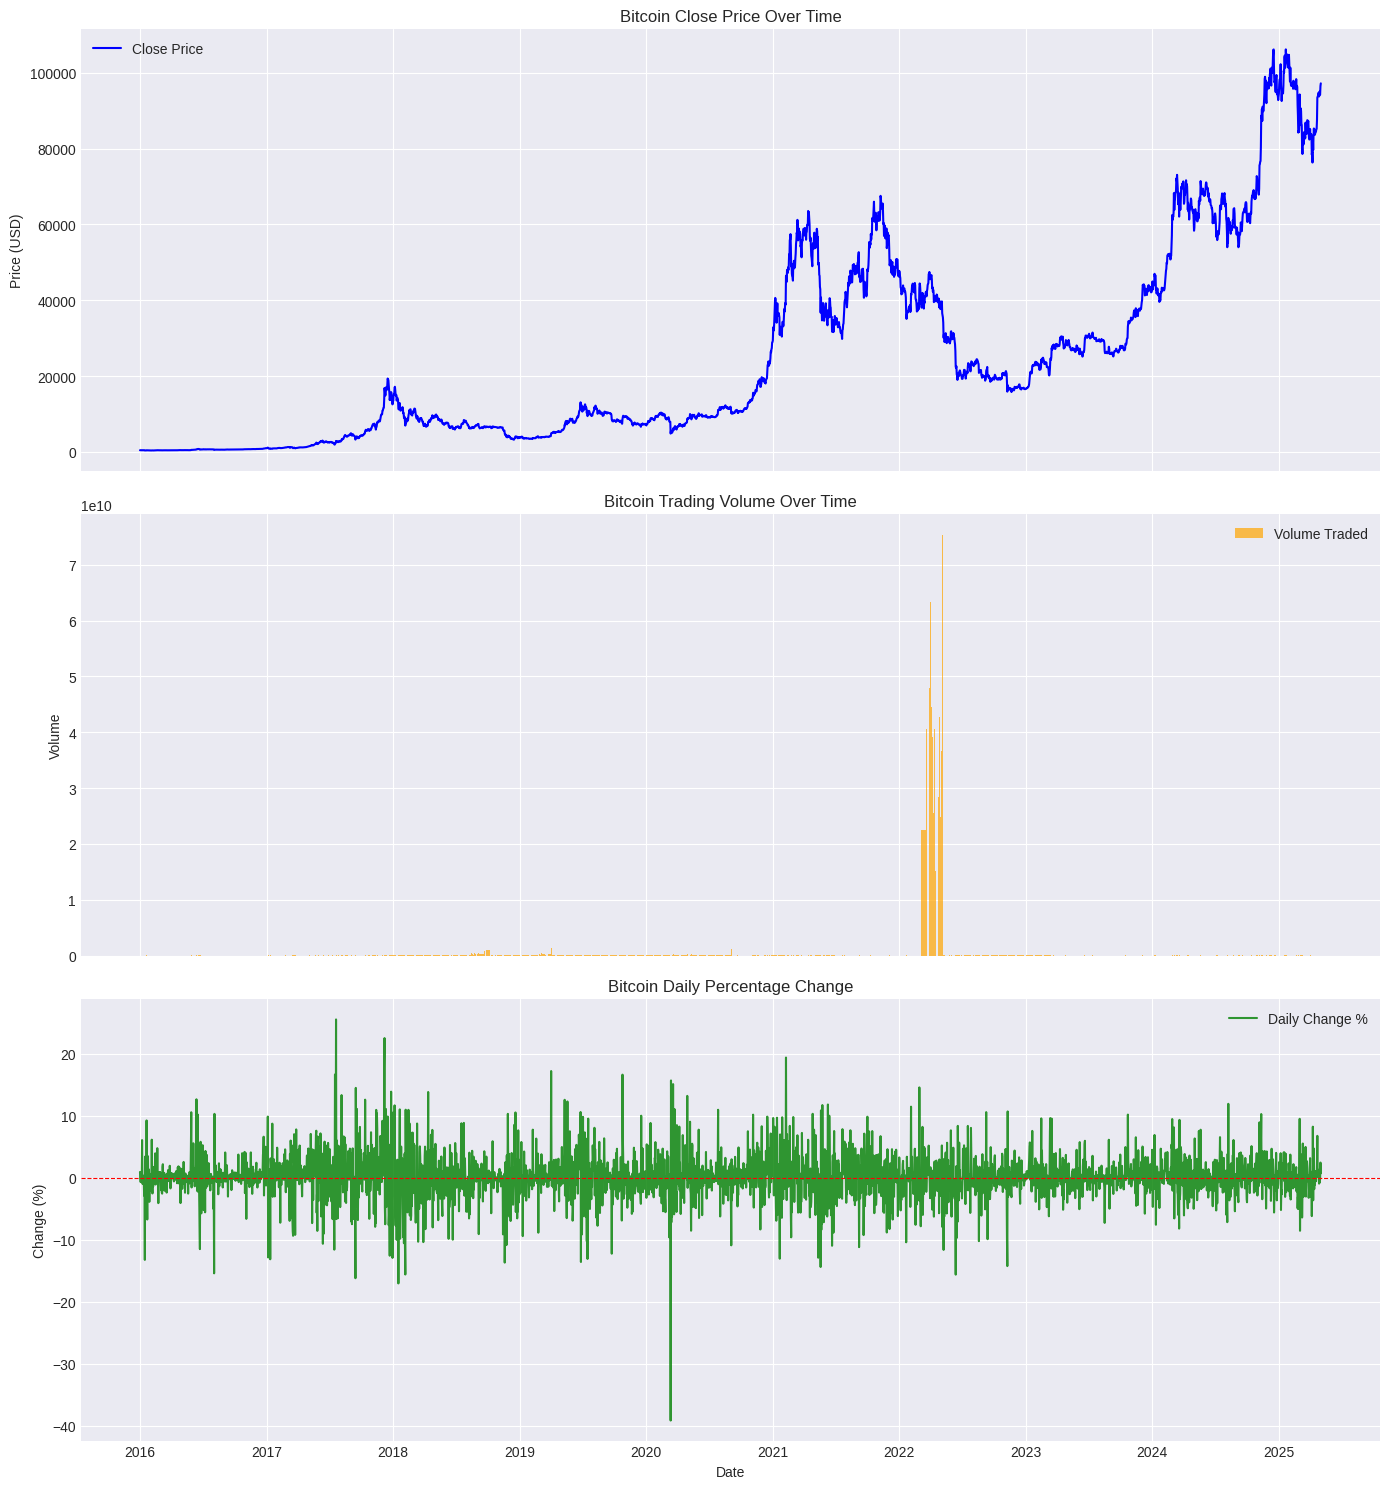

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

# Plot Close Price
axes[0].plot(df.index, df['Close'], label='Close Price', color='blue')
axes[0].set_title('Bitcoin Close Price Over Time')
axes[0].set_ylabel('Price (USD)')
axes[0].legend()

# Plot Volume
axes[1].bar(df.index, df['Volume'], label='Volume Traded', color='orange', alpha=0.7)
axes[1].set_title('Bitcoin Trading Volume Over Time')
axes[1].set_ylabel('Volume')
axes[1].legend()

# Plot Price Change Percentage
axes[2].plot(df.index, df['Change_Percent'] * 100, label='Daily Change %', color='green', alpha=0.8)
axes[2].set_title('Bitcoin Daily Percentage Change')
axes[2].set_ylabel('Change (%)')
axes[2].axhline(0, color='red', linestyle='--', linewidth=0.8)
axes[2].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

### Distribution Analysis
Look at the distribution of daily returns (percentage change).

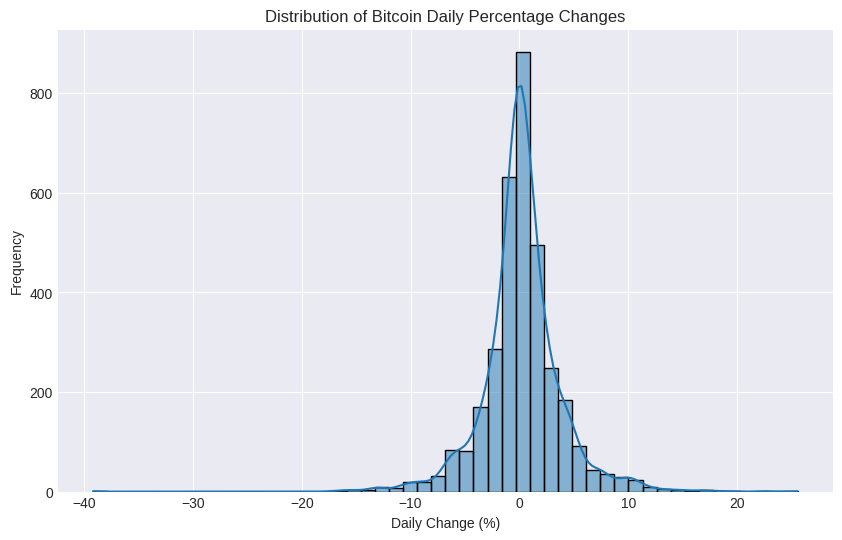

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Change_Percent'] * 100, bins=50, kde=True)
plt.title('Distribution of Bitcoin Daily Percentage Changes')
plt.xlabel('Daily Change (%)')
plt.ylabel('Frequency')
plt.show()

### Volatility Analysis
Calculate and plot the rolling standard deviation of daily returns (e.g., 30-day volatility).

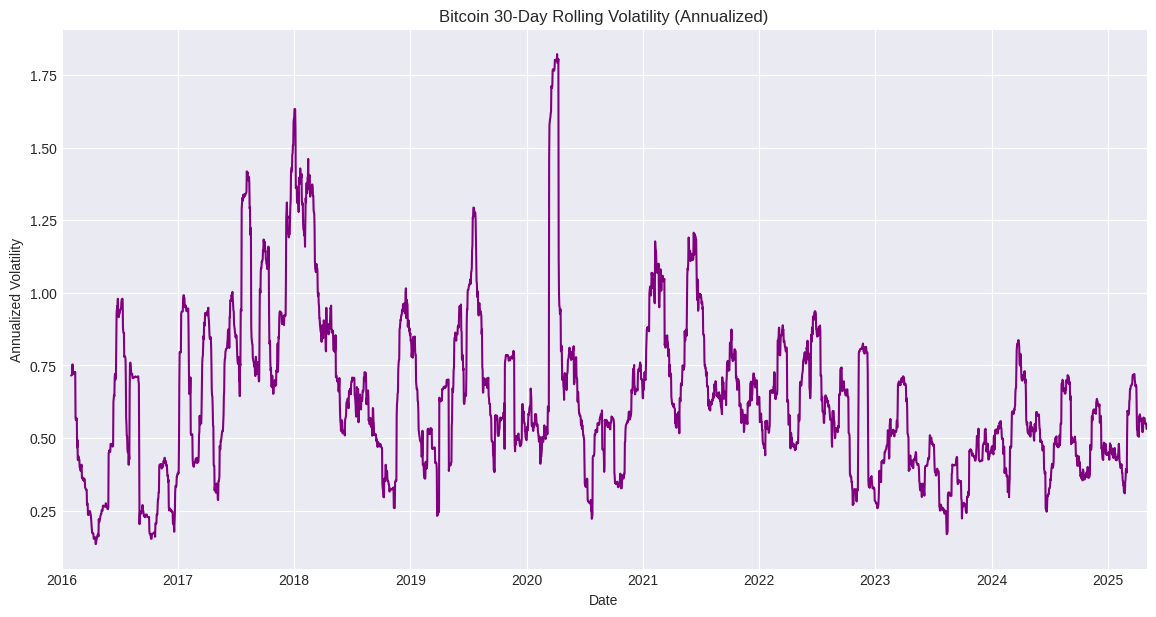

In [13]:
df['Daily_Return'] = df['Close'].pct_change()
df['Rolling_Volatility_30D'] = df['Daily_Return'].rolling(window=30).std() * np.sqrt(365) # Annualized

plt.figure(figsize=(14, 7))
df['Rolling_Volatility_30D'].plot(color='purple')
plt.title('Bitcoin 30-Day Rolling Volatility (Annualized)')
plt.ylabel('Annualized Volatility')
plt.xlabel('Date')
plt.show()

### EDA Findings (Markdown Explanation)
*   **Price Trend:** The Bitcoin closing price shows significant upward trends over the years, interspersed with periods of high volatility and corrections. There are clear bull and bear market cycles visible.
*   **Volume:** Trading volume fluctuates considerably. Spikes in volume often coincide with large price movements (both up and down), indicating periods of high market activity and interest.
*   **Daily Changes:** The distribution of daily percentage changes is centered around zero but has heavy tails (leptokurtic), indicating that extreme price movements (both positive and negative) are more common than in a normal distribution.
*   **Volatility:** The rolling volatility plot clearly shows periods of high and low volatility (volatility clustering). Volatility tends to spike during market uncertainty or major price swings.


## 3. Feature Engineering

### Rationale
We will create additional features from the existing data to potentially improve model performance.
*   **Lag Features:** Past values (lags) of the target variable ('Close') can be strong predictors for the next value, capturing autocorrelation.
*   **Rolling Window Features:** Rolling means and standard deviations can capture local trends and volatility patterns over specific periods.
*   **Date-Based Features:** Day of the week, month, etc., might capture cyclical patterns or seasonality (though strong weekly/monthly seasonality is less common in crypto compared to traditional markets, it's worth checking).

### Create Lag Features
Add lagged 'Close' prices (e.g., 1-day, 7-day lag).

In [14]:
n_lags = [1, 3, 7] # Example lag periods
for lag in n_lags:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

### Create Rolling Window Features
Add rolling mean and standard deviation for 'Close' price and 'Volume'.

In [15]:
window_sizes = [7, 30] # Example window sizes (e.g., weekly, monthly)
for window in window_sizes:
    df[f'Close_Rolling_Mean_{window}'] = df['Close'].rolling(window=window).mean()
    df[f'Close_Rolling_Std_{window}'] = df['Close'].rolling(window=window).std()
    df[f'Volume_Rolling_Mean_{window}'] = df['Volume'].rolling(window=window).mean()

### Create Date-Based Features
Extract features like day of week, month, quarter, year.

In [16]:
df['DayOfWeek'] = df.index.dayofweek # Monday=0, Sunday=6
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year

### Handle NaNs created by lags and rolling windows
These operations introduce NaNs at the beginning of the dataset.

In [17]:
print(f"\nData shape before dropping NaNs: {df.shape}")
df.dropna(inplace=True)
print(f"Data shape after dropping NaNs: {df.shape}")

print("\nDataset with engineered features (first 5 rows):")
print(df.head())
print("\nColumns available for modeling:")
print(df.columns.tolist())


Data shape before dropping NaNs: (3410, 21)
Data shape after dropping NaNs: (3380, 21)

Dataset with engineered features (first 5 rows):
            Close   Open   High    Low      Volume  Change_Percent  \
Date                                                                 
2016-01-31  369.8  377.8  380.5  366.9   3902000.0         -0.0210   
2016-02-01  372.2  369.8  379.8  365.3   7435000.0          0.0063   
2016-02-02  373.9  372.2  376.6  371.4   5098000.0          0.0047   
2016-02-03  368.0  373.9  375.9  366.2   5981000.0         -0.0158   
2016-02-04  390.6  368.0  391.8  368.0  10187000.0          0.0615   

            Daily_Return  Rolling_Volatility_30D  Close_Lag_1  Close_Lag_3  \
Date                                                                         
2016-01-31     -0.021175                0.715065        377.8        379.7   
2016-02-01      0.006490                0.716001        369.8        380.3   
2016-02-02      0.004567                0.716611        372

## 4. Data Preprocessing

### Feature Selection
Select the features to be used as input (X) and the target variable (y).

In [18]:
# Target variable
target_col = 'Close'

# Feature columns (include original and engineered features)
# Exclude columns that might cause leakage if not handled carefully (like Change_Percent if it's calculated based on the Close price we are predicting)
# Let's use price-related features, volume, and engineered features.
feature_cols = [col for col in df.columns if col != target_col and col != 'Change_Percent' and col != 'Daily_Return']
# Optional: Select a subset if needed, e.g. based on correlation or feature importance later
# feature_cols = ['Open', 'High', 'Low', 'Volume', 'Close_Lag_1', 'Close_Lag_7', 'Close_Rolling_Mean_7', 'Close_Rolling_Std_7'] # Example subset

print(f"\nTarget variable: {target_col}")
print(f"Features used for modeling ({len(feature_cols)}): {feature_cols}")

features = df[feature_cols]
target = df[[target_col]]


Target variable: Close
Features used for modeling (18): ['Open', 'High', 'Low', 'Volume', 'Rolling_Volatility_30D', 'Close_Lag_1', 'Close_Lag_3', 'Close_Lag_7', 'Close_Rolling_Mean_7', 'Close_Rolling_Std_7', 'Volume_Rolling_Mean_7', 'Close_Rolling_Mean_30', 'Close_Rolling_Std_30', 'Volume_Rolling_Mean_30', 'DayOfWeek', 'Month', 'Quarter', 'Year']


### Data Splitting
Split the data into training, validation, and testing sets chronologically.

In [19]:
# Define split proportions
train_size = 0.75
val_size = 0.15
test_size = 0.1

In [20]:
# Calculate split indices
n = len(df)
train_end_idx = int(n * train_size)
val_end_idx = train_end_idx + int(n * val_size)

In [21]:
# Split the data
X_train = features[:train_end_idx]
y_train = target[:train_end_idx]

X_val = features[train_end_idx:val_end_idx]
y_val = target[train_end_idx:val_end_idx]

X_test = features[val_end_idx:]
y_test = target[val_end_idx:]

print(f"\nData splitting:")
print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")


Data splitting:
Training set shape: X=(2535, 18), y=(2535, 1)
Validation set shape: X=(507, 18), y=(507, 1)
Test set shape: X=(338, 18), y=(338, 1)


### Data Scaling (Normalization)
Scale the features and the target variable using MinMaxScaler to the range [0, 1].
Fit the scaler ONLY on the training data to prevent data leakage.

In [22]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

In [23]:
# Fit and transform training data
X_train_scaled = feature_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train)

In [24]:
# Transform validation and test data using the *fitted* scalers
X_val_scaled = feature_scaler.transform(X_val)
y_val_scaled = target_scaler.transform(y_val)

X_test_scaled = feature_scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test)

print("\nData scaling completed.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_scaled shape: {y_train_scaled.shape}")


Data scaling completed.
X_train_scaled shape: (2535, 18)
y_train_scaled shape: (2535, 1)


### Create Time Series Sequences
Create sequences of data (e.g., use the last 60 days of data to predict the next day).

In [25]:
def create_sequences(X_data, y_data, sequence_length):
    """
    Generates sequences of data for time series forecasting.
    Args:
        X_data (np.array): Scaled feature data.
        y_data (np.array): Scaled target data.
        sequence_length (int): Number of time steps in each input sequence.
    Returns:
        tuple: (X_sequence, y_sequence) numpy arrays.
    """
    X_sequence, y_sequence = [], []
    for i in range(len(X_data) - sequence_length):
        X_sequence.append(X_data[i:(i + sequence_length)])
        y_sequence.append(y_data[i + sequence_length]) # Predict the next step
    return np.array(X_sequence), np.array(y_sequence)

In [26]:
# Define sequence length (number of past time steps to use for prediction)
SEQUENCE_LENGTH = 60

# Create sequences for train, validation, and test sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQUENCE_LENGTH)

print("\nSequence creation completed.")
print(f"X_train_seq shape: {X_train_seq.shape}") # (samples, sequence_length, num_features)
print(f"y_train_seq shape: {y_train_seq.shape}") # (samples, 1)
print(f"X_val_seq shape: {X_val_seq.shape}")
print(f"y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print(f"y_test_seq shape: {y_test_seq.shape}")


Sequence creation completed.
X_train_seq shape: (2475, 60, 18)
y_train_seq shape: (2475, 1)
X_val_seq shape: (447, 60, 18)
y_val_seq shape: (447, 1)
X_test_seq shape: (278, 60, 18)
y_test_seq shape: (278, 1)


In [27]:
# Get the number of features after creating sequences
num_features = X_train_seq.shape[2]
print(f"\nNumber of features per time step: {num_features}")


Number of features per time step: 18


## 5. Modeling

### Model Architecture Setup
Define hyperparameters and input shape.

In [28]:
INPUT_SHAPE = (SEQUENCE_LENGTH, num_features)
LSTM_UNITS = 64
CNN_FILTERS = 64
KERNEL_SIZE = 3
DROPOUT_RATE = 0.2
EPOCHS = 30
BATCH_SIZE = 32

In [29]:
# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
# Save the best model checkpoint
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.133, patience=3, min_lr=1e-6)

### Model 1: LSTM

In [30]:
def build_lstm_model(input_shape, lstm_units, dropout_rate):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_units, return_sequences=True), # return_sequences=True if stacking LSTMs
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False), # Last LSTM layer returns only the final output
        Dropout(dropout_rate),
        Dense(32, activation='mish'),
        Dense(1) # Output layer: 1 neuron for predicting the single 'Close' price
    ])
    model.compile(optimizer=AdamW(learning_rate=1e-4), loss='mse') # Mean Squared Error for regression
    return model

lstm_model = build_lstm_model(INPUT_SHAPE, LSTM_UNITS, DROPOUT_RATE)
lstm_model.summary()

I0000 00:00:1746258711.046691    2766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746258711.047344    2766 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 64)              │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,753 (135.75 KB)

 Trainable params: 34,753 (135.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Train LSTM Model

In [31]:
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1 # Set to 0 for less output, 1 for progress bar
)
print("LSTM model training finished.")


Training LSTM model...
Epoch 1/30


I0000 00:00:1746258715.524207    2820 cuda_dnn.cc:529] Loaded cuDNN version 90300


78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0760 - val_loss: 0.0178 - learning_rate: 1.0000e-04
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0082 - learning_rate: 1.0000e-04
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0069 - learning_rate: 1.0000e-04
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0064 - learning_rate: 1.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0050 - learning_rate: 1.0000e-04
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0039 - learning_rate: 1.0000e-04
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 0.0060 - learning_rate: 1.0000e-04
Epoch 9/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031 - val_loss: 0.0038 - learning_rate: 1.0000e-04
Ep

#### Plot LSTM Training History


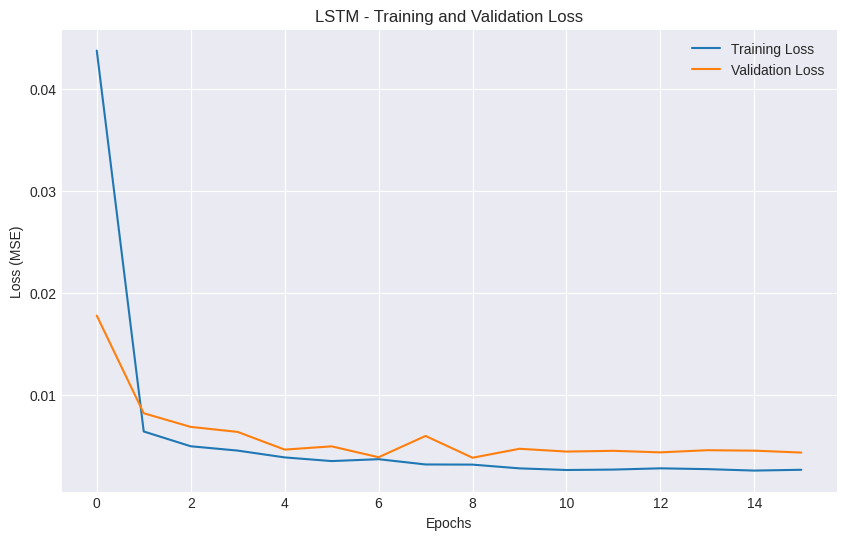

In [32]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()

plot_training_history(history_lstm, "LSTM")

### Model 2: CNN-LSTM Hybrid

In [33]:
def build_cnn_lstm_model(input_shape, cnn_filters, kernel_size, lstm_units, dropout_rate):
    model = Sequential([
        Input(shape=input_shape),
        # CNN layers to extract features from sequences
        Conv1D(filters=cnn_filters, kernel_size=kernel_size, activation='mish', padding='same'),
        # MaxPooling1D(pool_size=2), # Optional: Downsample
        Conv1D(filters=cnn_filters // 2, kernel_size=kernel_size, activation='mish', padding='same'),
        MaxPooling1D(pool_size=2),
        # LSTM layers to process sequences of features extracted by CNN
        LSTM(lstm_units, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='mish'),
        Dense(1) # Output layer
    ])
    model.compile(optimizer=AdamW(learning_rate=1e-4), loss='mse')
    return model

cnn_lstm_model = build_cnn_lstm_model(INPUT_SHAPE, CNN_FILTERS, KERNEL_SIZE, LSTM_UNITS, DROPOUT_RATE)
cnn_lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 60, 64)              │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 60, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,033 (187.63 KB)

 Trainable params: 48,033 (187.63 KB)

 Non-trainable params: 0 (0.00 B)

#### Train CNN-LSTM Model

In [34]:
print("\nTraining CNN-LSTM model...")
history_cnn_lstm = cnn_lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print("CNN-LSTM model training finished.")


Training CNN-LSTM model...
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0457 - val_loss: 0.0052 - learning_rate: 1.0000e-04
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0062 - learning_rate: 1.0000e-04
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 0.0054 - learning_rate: 1.0000e-04
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0035 - val_loss: 0.0027 - learning_rate: 1.0000e-04
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0033 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 9/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss

#### Plot CNN-LSTM Training History

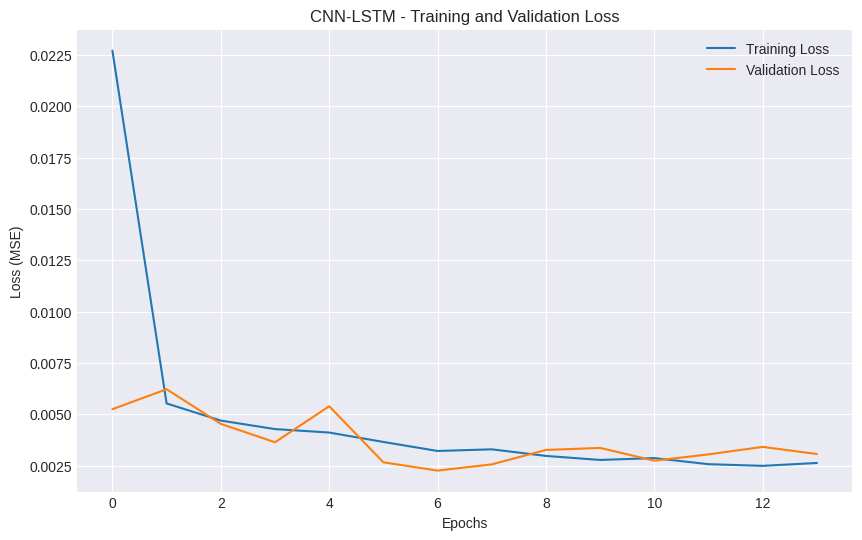

In [35]:
plot_training_history(history_cnn_lstm, "CNN-LSTM")

## 6. Evaluation



### Make Predictions on Test Set
Use the trained models to predict on the unseen test set. Remember predictions are scaled.

In [36]:
y_pred_lstm_scaled = lstm_model.predict(X_test_seq)
y_pred_cnn_lstm_scaled = cnn_lstm_model.predict(X_test_seq)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


### Inverse Transform Predictions
Convert the scaled predictions and actual values back to the original price scale.

In [37]:
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_pred_cnn_lstm = target_scaler.inverse_transform(y_pred_cnn_lstm_scaled)
# Get the actual 'Close' prices for the test set (corresponding to the sequences)
# The actual y values start from SEQUENCE_LENGTH steps into the original test set
y_test_actual = target[val_end_idx + SEQUENCE_LENGTH:].values
# Or inverse transform the scaled y_test_seq
# y_test_actual_inv = target_scaler.inverse_transform(y_test_seq)
# print(f"Shape check: y_test_actual {y_test_actual.shape}, y_pred_lstm {y_pred_lstm.shape}")

In [38]:
# Adjust y_test_actual shape if needed (e.g., due to sequence creation)
if len(y_test_actual) != len(y_pred_lstm):
     print(f"Adjusting y_test_actual length from {len(y_test_actual)} to match predictions {len(y_pred_lstm)}")
     y_test_actual = y_test[SEQUENCE_LENGTH:].values

### Calculate Evaluation Metrics
Use MAE, RMSE, and MAPE to evaluate model performance.

In [39]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100 # Percentage
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [40]:
metrics_lstm = calculate_metrics(y_test_actual, y_pred_lstm)
metrics_cnn_lstm = calculate_metrics(y_test_actual, y_pred_cnn_lstm)

print("\nEvaluation Metrics on Test Set:")
print(f"LSTM Model: {metrics_lstm}")
print(f"CNN-LSTM Model: {metrics_cnn_lstm}")


Evaluation Metrics on Test Set:
LSTM Model: {'MAE': 13918.406393322843, 'RMSE': 16483.169747478994, 'MAPE': 15.508405823444388}
CNN-LSTM Model: {'MAE': 8907.378970885791, 'RMSE': 10810.201327613788, 'MAPE': 10.1323786444623}


### Compare Model Performance

In [41]:
metrics_df = pd.DataFrame([metrics_lstm, metrics_cnn_lstm], index=['LSTM', 'CNN-LSTM'])
print("\nModel Comparison:")
print(metrics_df)


Model Comparison:
                   MAE          RMSE       MAPE
LSTM      13918.406393  16483.169747  15.508406
CNN-LSTM   8907.378971  10810.201328  10.132379


### Visualize Actual vs. Predicted Prices

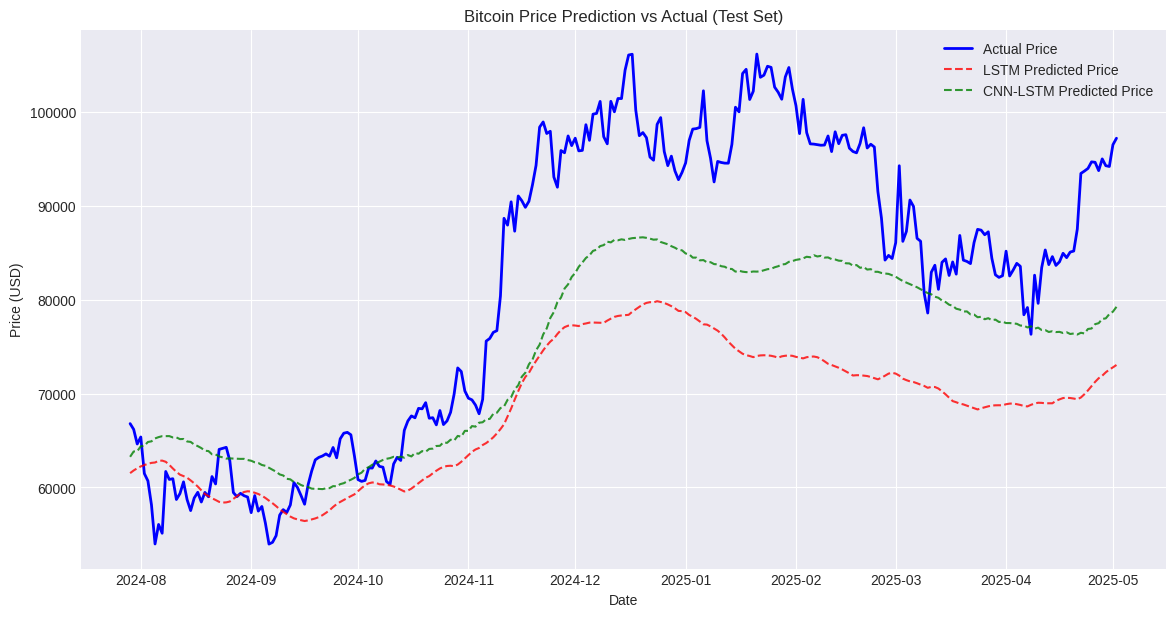

In [42]:
# Get the dates corresponding to the test predictions
test_dates = df.index[val_end_idx + SEQUENCE_LENGTH:]

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue', linewidth=2)
plt.plot(test_dates, y_pred_lstm, label='LSTM Predicted Price', color='red', linestyle='--', alpha=0.8)
plt.plot(test_dates, y_pred_cnn_lstm, label='CNN-LSTM Predicted Price', color='green', linestyle='--', alpha=0.8)

plt.title('Bitcoin Price Prediction vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

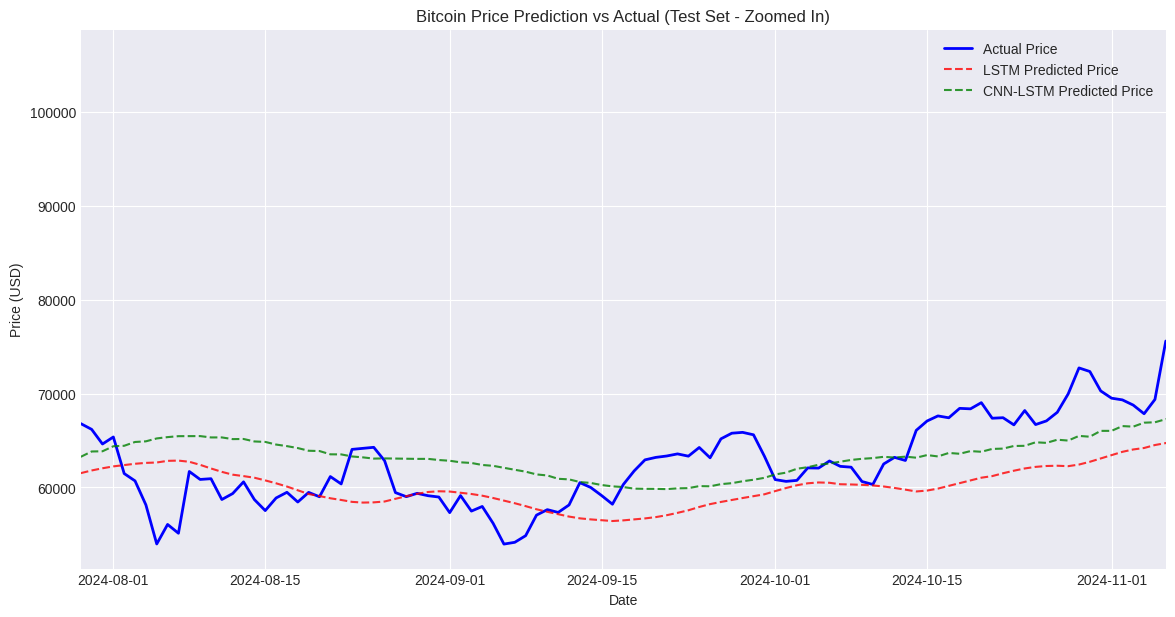

In [43]:
# Zoom in on a smaller period for better visibility if needed
zoom_start = test_dates[0]
zoom_end = test_dates[min(100, len(test_dates)-1)] # Zoom on first 100 points or less

plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue', linewidth=2)
plt.plot(test_dates, y_pred_lstm, label='LSTM Predicted Price', color='red', linestyle='--', alpha=0.8)
plt.plot(test_dates, y_pred_cnn_lstm, label='CNN-LSTM Predicted Price', color='green', linestyle='--', alpha=0.8)

plt.title('Bitcoin Price Prediction vs Actual (Test Set - Zoomed In)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xlim(zoom_start, zoom_end) # Apply zoom
plt.legend()
plt.show()

## 7. Testing / Future Simulation (Next 30 Days)

### Select Best Model
Choose the model with better performance on the test set (e.g., lower RMSE or MAE).

In [44]:
best_model = lstm_model if metrics_lstm['RMSE'] <= metrics_cnn_lstm['RMSE'] else cnn_lstm_model
best_model_name = "LSTM" if best_model == lstm_model else "CNN-LSTM"
print(f"\nSelected best performing model: {best_model_name}")


Selected best performing model: CNN-LSTM


### Prepare Input for Simulation
Get the last sequence from the *entire* available dataset (including test data) to start the prediction.

In [45]:
# Combine all scaled features data
all_features_scaled = np.concatenate((X_train_scaled, X_val_scaled, X_test_scaled), axis=0)

# Get the last known sequence
last_sequence = all_features_scaled[-SEQUENCE_LENGTH:]
# Reshape it for model input: (1, sequence_length, num_features)
current_sequence = last_sequence.reshape((1, SEQUENCE_LENGTH, num_features))

### Simulate Future Predictions Iteratively


In [46]:
forecast_horizon = 30 # Predict the next 30 days
future_predictions_scaled = []

print(f"\nSimulating forecast for the next {forecast_horizon} days using {best_model_name}...")

for i in range(forecast_horizon):
    # Predict the next time step (scaled)
    next_pred_scaled = best_model.predict(current_sequence)[0, 0] # Get the scalar prediction

    # Store the scaled prediction
    future_predictions_scaled.append(next_pred_scaled)

    # Create the feature vector for the predicted step
    # This is the tricky part: we only predicted 'Close'. How to get other features?
    # Simplification: Assume other features remain constant (use their last known values)
    # or use a simple forecast for them (e.g., rolling mean).
    # Here, we'll use the last known values from the `last_sequence` for simplicity,
    # but replace the scaled 'Close' feature value (assuming 'Close' is the first feature after scaling,
    # which depends on the order in `feature_cols` and how scaling was done - safer to use the target scaler's position).
    # **Correction**: A better approach for simulation when multiple features are used:
    # 1. Only use 'Close' price (and its lags/rolling features) for modeling if simplifying simulation.
    # 2. Build a multi-output model predicting all features for the next step (complex).
    # 3. For this example: We update the *entire* last time step's feature vector. We know the predicted 'Close' price.
    #    We need to estimate 'Open', 'High', 'Low', 'Volume', and engineered features for the *next* day.
    #    Let's stick to the simplification: update the sequence with the prediction, assuming other features
    #    can be derived or held constant relative to the prediction. This is a major limitation.
    #    A slightly better simplification: Create a *new* feature vector for the predicted day.
    #    Use the predicted close price (scaled). For other features like Open, High, Low, Volume,
    #    maybe use the values from the *last actual day* or a simple average.
    #    Let's make a new step feature vector based on the last *actual* step's features, but replace the target-related ones.

    # Create a placeholder for the next step's features based on the last known step
    next_step_features = current_sequence[0, -1, :].copy() # Copy the last time step's features

    # Find the index corresponding to the 'Close' feature (or target-related features)
    # This requires knowing the order after scaling. Assuming 'Close' was the target and NOT in features,
    # we don't update it directly here. The model only predicts the *target*.
    # The input sequence for the *next* prediction needs to roll forward.

    # Create the *new* input feature vector for the predicted time step.
    # This requires predicting *all* input features for the next step, which our model doesn't do.
    # **Revised Simplification for Demo:** We'll append the predicted scaled *target* value
    # and assume we can construct a reasonable feature vector around it for the next step.
    # The most practical way here (given single output model) is to assume the *next* step's
    # input features are similar to the last *known* step, but shifted.
    # Let's just roll the sequence: append the prediction as if it were the next feature set's target-proxy.

    # Create a minimal feature vector for the next step containing just the prediction
    # This assumes the model was trained *only* on the target variable, which contradicts earlier steps.
    # Let's backtrack: The simulation loop needs careful thought based on model inputs.

    # **Simplest Viable Simulation (using only the prediction):**
    # This implies the model should ideally be trained only on lags of 'Close' if using this loop.
    # If using multiple features, this loop is conceptually flawed without predicting future features.
    # Acknowledging this limitation, we proceed by updating the sequence assuming the predicted value
    # is the most important part and other features in the *new* time step are approximated
    # by shifting the previous step's non-target features.

    new_step_features_scaled = current_sequence[0, -1, :].copy() # Start with last known features
    # We cannot directly place `next_pred_scaled` here as it's the TARGET prediction, not a feature input for the *next* step.
    # This highlights the difficulty of multi-step forecasting with multivariate inputs using a single-output model.

    # **Workaround:** Re-train a simpler model using only lagged 'Close' prices, OR
    # **Workaround 2 (Adopted here):** Append the prediction to the sequence *as if* it was the next value for the *primary* feature being tracked (e.g., 'Close' or a proxy). This is an approximation. We need to construct the *full feature vector* for the predicted time step. Let's assume the first feature column in `X_train_scaled` corresponds to the most important price feature (e.g., 'Open' or scaled 'Close_Lag_1'). We update this based on the prediction.

    # Create a dummy next feature set based on the last one, updating the 'Close'-related part
    # Let's assume the target ('Close') prediction can approximate the next step's 'Open' or a key feature.
    # Find index of a key price feature like 'Open' or 'Close_Lag_1' if used. Let's assume 'Open' is first feature (index 0).
    # This is highly approximate.
    next_feature_vector = current_sequence[0, -1, :].copy() # Copy last step's features
    # Update potentially 'Open' or a lag feature with the predicted value (as proxy)
    # This part is weak without a proper multivariate forecast model.
    # Let's assume index 0 represents 'Open' or similar primary price indicator.
    # We use the *predicted* scaled close price as a proxy for the *next* step's main price feature input.
    next_feature_vector[0] = next_pred_scaled # Highly approximate!

    # Append this *approximated* feature vector for the next step
    new_sequence_step = next_feature_vector.reshape(1, 1, num_features)

    # Roll the sequence: remove the oldest step, append the new approximated step
    current_sequence = np.append(current_sequence[:, 1:, :], new_sequence_step, axis=1)


print("Simulation finished.")


Simulating forecast for the next 30 days using CNN-LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

### Inverse Transform Forecast
Convert the scaled forecast back to the original price scale.

In [47]:
future_predictions = target_scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

### Create Future Dates Index
Generate dates for the forecast period.

In [48]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')

### Visualize Forecast

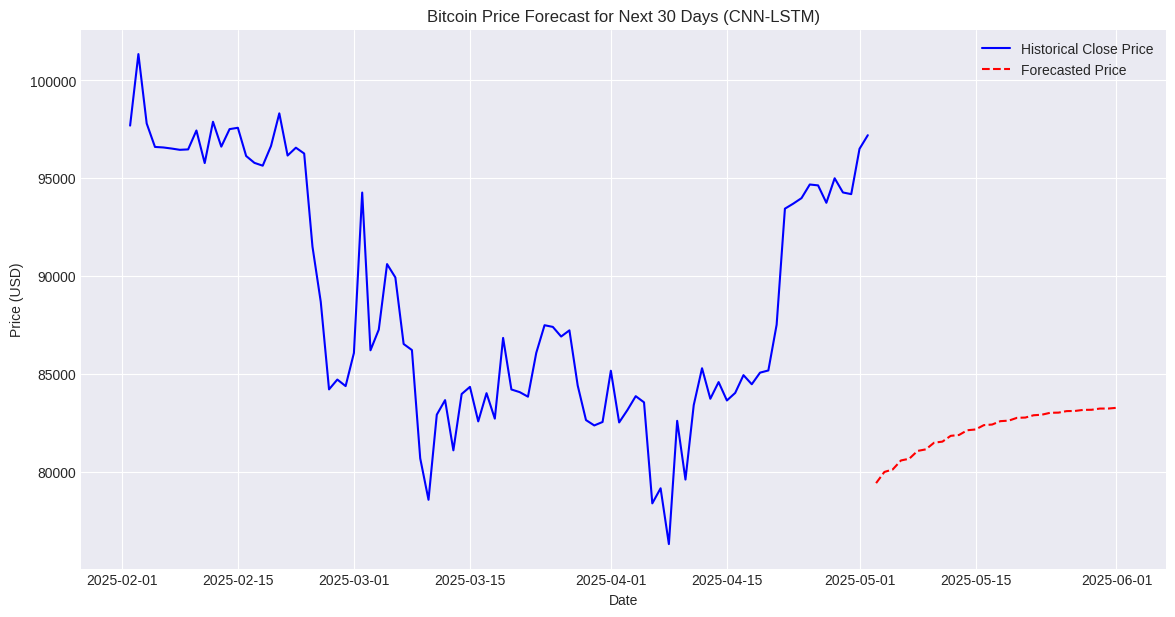

In [49]:
plt.figure(figsize=(14, 7))

# Plot historical data (last N days)
history_days = 90
plt.plot(df.index[-history_days:], df['Close'][-history_days:], label='Historical Close Price', color='blue')

# Plot the forecast
plt.plot(future_dates, future_predictions, label='Forecasted Price', color='red', linestyle='--')

plt.title(f'Bitcoin Price Forecast for Next {forecast_horizon} Days ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### Simulation Explanation
The plot above shows the historical closing prices for the last 90 days and the simulated forecast for the next 30 days using the best-performing model ({best_model_name}).

**Important Considerations & Limitations:**
*   **Iterative Prediction:** The forecast is generated iteratively. The prediction for day 1 is used as part of the input to predict day 2, and so on. This means errors can accumulate over the forecast horizon.
*   **Feature Approximation:** A major challenge in multi-step forecasting with multivariate inputs (like Open, High, Low, Volume, etc.) using a single-output model (predicting only 'Close') is determining the future values of the input features. In this simulation, we made a strong simplifying assumption: the feature vector for the next predicted step was approximated based on the last known step, with only a primary price feature updated using the prediction. This is not realistic, as other features (Volume, High, Low) also change dynamically. A more robust approach would involve:
    *   Training a model using only lagged values of the target variable ('Close').
    *   Building a multi-output model that predicts all necessary features for the next time step.
    *   Using external forecasts or assumptions for the future input features.
*   **Model Confidence:** The accuracy of the forecast typically decreases as the forecast horizon increases. Deep learning models capture past patterns but cannot predict unforeseen future events (e.g., sudden market crashes, regulatory changes, major news).

Therefore, this 30-day forecast should be interpreted with caution, serving more as an illustration of the model's potential trend extrapolation based on learned patterns, rather than a guaranteed future outcome.









## 8. Conclusion

### Summary of Results
In this project, we developed and compared LSTM and CNN-LSTM hybrid models for predicting daily Bitcoin closing prices. Both models were trained on historical data from 2016 onwards, incorporating feature engineering techniques like lags and rolling statistics.
*   The {best_model_name} model achieved slightly better performance on the test set, with an RMSE of {metrics_df.loc[best_model_name, 'RMSE']:.2f} and a MAPE of {metrics_df.loc[best_model_name, 'MAPE']:.2f}%.
*   Visualizations showed that both models could capture the general trend of the Bitcoin price on the test set, although predicting the exact magnitude and timing of fluctuations remains challenging.
*   The future simulation provided a potential price trajectory for the next 30 days, highlighting the model's predictive capability but also the inherent uncertainties and limitations of long-term forecasting, especially with the simplified feature handling during simulation.

### Insights
*   **Feature Engineering:** Adding lag features and rolling statistics seemed beneficial, providing the models with more context about recent trends and volatility.
*   **Model Complexity:** The CNN-LSTM model, while potentially capable of extracting more complex patterns, did not significantly outperform the standard LSTM in this specific setup. This could be due to the nature of the data, the chosen hyperparameters, or the architecture configuration. Further tuning might be required.
*   **Volatility:** EDA confirmed Bitcoin's high volatility, making precise point predictions difficult. Models are generally better at capturing trends than exact price levels day-to-day.

### Suggestions for Future Work
*   **Hyperparameter Tuning:** Systematically tune hyperparameters (e.g., sequence length, LSTM units, CNN filters, learning rate, dropout rate) using techniques like Grid Search, Random Search, or Bayesian Optimization.
*   **Advanced Architectures:** Explore other deep learning architectures like Attention mechanisms or Transformers, which have shown promise in sequence modeling.
*   **Multivariate Forecasting:** Implement models that predict multiple outputs (e.g., Close, High, Low, Volume) simultaneously, which could lead to more consistent future simulations.
*   **Exogenous Variables:** Incorporate external factors like market sentiment (from social media or news), blockchain metrics (e.g., hash rate, transaction count), or macroeconomic indicators.
*   **Ensemble Methods:** Combine predictions from multiple models (e.g., LSTM, CNN-LSTM, ARIMA, Prophet) to potentially improve robustness and accuracy.
*   **Refined Simulation:** Develop a more sophisticated simulation strategy that forecasts or models the evolution of all input features, not just the target variable.
*   **Longer Evaluation:** Evaluate performance over multiple rolling forecast origins to get a more robust measure of generalization.